### Setup & Data

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-11-22 02:06:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-11-22 02:06:46 (12.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [6]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

## Data visualization and pre-processing

* review class target - 'Loan Status'
* 'Paidoff' & 'Collection' target by gender, principal, age
* create 'day of week' & 'weekend' variables

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00  45.91 MB/s


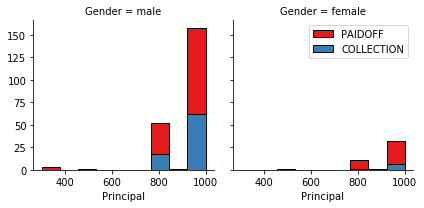

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

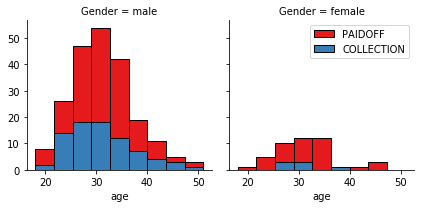

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

#### observation that 'dayofweek' view and 'weekend' values correlate to class
effective date > dayofweek > weekend = dayofweek > 3

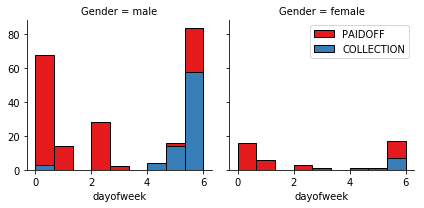

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Create numeric ('dummy') values & One Hot Encoding

#### target by gender & conversion

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### target by education level & data conversion

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


#### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


#### target data (y) & conversion

In [19]:
df_target = df[["loan_status"]]
df_target.head()

,loan_status
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [20]:
target = pd.get_dummies(df_target['loan_status'])
target.drop(['COLLECTION'], axis = 1,inplace=True)
target.head()

,PAIDOFF
0,1
1,1
2,1
3,1
4,1


In [21]:
y = target.values
y[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

## Split Train/Test & scale the data

In [22]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (311, 9) (311, 1)
Test set: (35, 9) (35, 1)


# Training Set - Classification 
#### Below is the training and model validation (using 10% of training data for validation)

* Model 1 - K Nearest Neighbor(KNN)
* Model 2 -- Decision Tree
* Model 3 - Support Vector Machine
* Model 4 - Logistic Regression

### Model 1 - K Nearest Neighbor(KNN)
*summary of steps*
* step 1: review accuracy of train/test based on K
* step 2: build model using highest accuracy of K
* step 3: check accuracy of model

In [24]:
from sklearn.neighbors import KNeighborsClassifier

#### step 1: review range of accuracy for various K values

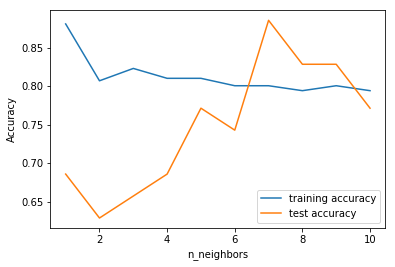

In [25]:
training_accuracy = []
test_accuracy = []
# try n neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # here i build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train.ravel())
    #here i recorded training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # here i recorded generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

it appears highest accuracy in training set would be K value of 5

#### step 2: build the model using highest accuracy of k: 

In [26]:
k = 7
#here i train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train.ravel())
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

#### step 3: check accuracy:

In [27]:
yhat = neigh.predict(X_test)
print("Model 1: KNN Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Model 1: KNN Validation set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Model 1: KNN Jaccard Score:",jaccard_similarity_score(y_test, yhat))
print("Model 1: KNN F1 Score", f1_score(y_test, yhat))

Model 1: KNN Train set Accuracy:  0.800643086817
Model 1: KNN Validation set Accuracy:  0.885714285714
Model 1: KNN Jaccard Score: 0.885714285714
Model 1: KNN F1 Score 0.931034482759


# Decision Tree

*summary of steps*
* step 1: create tree model based on # of parameters
* step 2: fit model to training data & create predicted values for test set 
* step 3: check accuracy of model

In [28]:
from sklearn.tree import DecisionTreeClassifier

#### step 1: create tree model based on # of parameters

In [29]:
d_Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
d_Tree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### step 2: fit model to training data & create predicted values for test

In [30]:
# fit model to the training data
d_Tree.fit(X_train,y_train)
# use fitted model to predict test target values
Tree_predict = d_Tree.predict(X_test)

#### step 3: test accuracy

In [31]:
print("Model 2: D_tree Train set Accuracy: ", metrics.accuracy_score(y_train, d_Tree.predict(X_train)))
print("Model 2: D_tree Validation set Accuracy: ", metrics.accuracy_score(y_test, Tree_predict))
print("Model 2: D_tree Jaccard Score:",jaccard_similarity_score(y_test, Tree_predict))
print("Model 2: D_tree F1 Score", f1_score(y_test, Tree_predict))

Model 2: D_tree Train set Accuracy:  0.752411575563
Model 2: D_tree Validation set Accuracy:  0.685714285714
Model 2: D_tree Jaccard Score: 0.685714285714
Model 2: D_tree F1 Score 0.8


# Support Vector Machine

In [32]:
from sklearn import svm
clf = svm.SVC(kernel='linear')

In [33]:
clf.fit(X_train, y_train.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
# use fitted model to predict test target values
svm_predict = clf.predict(X_test)

In [35]:
print("Model 3: SVM Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Model 3: SVM Validation set Accuracy: ", metrics.accuracy_score(y_test, svm_predict))
print("Model 3: SVM Jaccard Score:",jaccard_similarity_score(y_test, svm_predict))
print("Model 3: SVM F1 Score", f1_score(y_test, svm_predict))

Model 3: SVM Train set Accuracy:  0.739549839228
Model 3: SVM Validation set Accuracy:  0.857142857143
Model 3: SVM Jaccard Score: 0.857142857143
Model 3: SVM F1 Score 0.923076923077


# Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_train,y_train.ravel())
LR

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
# use fitted model to predict test target values
LR_predicted = LR.predict(X_test)
LR_predicted

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [38]:
print("Model 4: Log_reg Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Model 4: Log_reg Validation set Accuracy: ", metrics.accuracy_score(y_test, LR_predicted))
print("Model 4: Log_reg Jaccard Score:",jaccard_similarity_score(y_test, LR_predicted))
print("Model 4: Log_reg F1 Score", f1_score(y_test, LR_predicted))
print("Model 4: Log_reg log_loss Score", log_loss(y_test, LR_predicted))

Model 4: Log_reg Train set Accuracy:  0.739549839228
Model 4: Log_reg Validation set Accuracy:  0.8
Model 4: Log_reg Jaccard Score: 0.8
Model 4: Log_reg F1 Score 0.881355932203
Model 4: Log_reg log_loss Score 6.9078238159


# Model Evaluation using Test set

First, download and load the test set:

In [39]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-11-22 02:10:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2018-11-22 02:10:58 (688 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Data transformation of Test Set in preparation for model testing

In [40]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [41]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [42]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [43]:
Test_feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_feature = pd.concat([Test_feature,pd.get_dummies(test_df['education'])], axis=1)
Test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,50,1,0,1,0,0,0
1,300,7,35,0,1,0,0,1,0
2,1000,30,43,1,1,0,1,0,0
3,1000,30,26,0,1,0,0,0,1
4,800,15,29,0,1,1,0,0,0


In [44]:
test_df_target = test_df[["loan_status"]]
test_df_target.head()

,loan_status
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [45]:
test_target = pd.get_dummies(test_df_target['loan_status'])
test_target.drop(['COLLECTION'], axis = 1,inplace=True)
test_target.head()

,PAIDOFF
0,1
1,1
2,1
3,1
4,1


In [46]:
y_true = test_target.values
y_true[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [47]:
X_test = preprocessing.StandardScaler().fit(Test_feature).transform(Test_feature)
X_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.19611614, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  5.09901951, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.19611614, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.19611614,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.19611614, -0.86135677]])

assign values for test metrics for each model

In [50]:
KNN_j = jaccard_similarity_score(y_true,neigh.predict(X_test))
KNN_f1 = f1_score(y_true,neigh.predict(X_test))
dtree_j = jaccard_similarity_score(y_true,d_Tree.predict(X_test))
dtree_f1 = f1_score(y_true,d_Tree.predict(X_test))
svm_j = jaccard_similarity_score(y_true,clf.predict(X_test))
svm_f1 = f1_score(y_true,clf.predict(X_test))
logreg_j = jaccard_similarity_score(y_true,LR.predict(X_test))
logreg_f1 = f1_score(y_true,LR.predict(X_test))
logreg_loss = log_loss(y_true, LR.predict(X_test))

create pd.Dataframe of test metrics & recommend best fit

In [51]:
col_names =  ['Algorithm','Jaccard', 'F1-score','LogLoss','recommendation']
Report_df = pd.DataFrame(columns = col_names)
Report_df.loc[len(Report_df)] = ['KNN', KNN_j,KNN_f1,'NA','']
Report_df.loc[len(Report_df)] = ['Decision Tree', dtree_j,dtree_f1,'NA','Best Fit']
Report_df.loc[len(Report_df)] = ['SVM', svm_j,svm_f1,'NA','']
Report_df.loc[len(Report_df)] = ['Log_Reg', logreg_j,logreg_f1,logreg_loss,'']
Report_df

,Algorithm,Jaccard,F1-score,LogLoss,recommendation
0,KNN,0.722222,0.823529,NA,
1,Decision Tree,0.814815,0.875000,NA,Best Fit
2,SVM,0.740741,0.851064,NA,
3,Log_Reg,0.796296,0.879121,7.03584,
